<a href="https://colab.research.google.com/github/OnlySem/ITMO/blob/main/%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты библиотек

In [110]:
%%capture
!pip install --upgrade matplotlib > None
!pip install -U scikit-learn > None
!pip install catboost

In [112]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import load_diabetes, load_breast_cancer, make_classification, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from catboost import CatBoostRegressor

import shap

%matplotlib inline

#Задание №1

## Информация о базе данных

Набор данных состоит из анонимных данных о заработной плате научных сотрудников различных стран по годам.

In [66]:
path = 'https://raw.githubusercontent.com/OnlySem/ITMO/refs/heads/main/DataScience_salaries_2024.csv'
data = pd.read_csv(path)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L
1,2021,MI,FT,BI Data Analyst,11000000,HUF,36259,HU,50,US,L
2,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
3,2021,MI,FT,ML Engineer,8500000,JPY,77364,JP,50,JP,S
4,2022,SE,FT,Lead Machine Learning Engineer,7500000,INR,95386,IN,50,IN,L


In [67]:
data.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [68]:
data.shape

(14838, 11)

In [69]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,14838.000000,1.483800e+04,14838.000000,14838.000000
mean,2023.138900,1.650227e+05,149874.718763,32.760480
std,0.700799,3.562354e+05,69009.181349,46.488278
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.021000e+05,102000.000000,0.000000
50%,2023.000000,1.422000e+05,141300.000000,0.000000
75%,2024.000000,1.875000e+05,185900.000000,100.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


In [70]:
data.dtypes

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


База данных заполнена полностью, пропусков нет

In [71]:
data.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [72]:
cat_cols = data.select_dtypes(include='object')
num_col = data.select_dtypes(exclude='object')

База данных содержит 4 типа квалификации сотрудников, 4 типа трудоустройства сотрудников, 153 должности, 23 типа валюты заработной платы, 88 страны проживания сотрудников, 77 стран расположения компаний и 3 типа размера компании.

In [73]:
cat_cols.describe()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,14838,14838,14838,14838,14838,14838,14838
unique,4,4,153,23,88,77,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,9696,14772,3162,13682,12926,12975,13674


тип трудоустройства
FT - Full-time, PT - part-time, CT - contract, FL - freelance

In [74]:
cat_cols['employment_type'].value_counts()

,count
employment_type,
FT,14772
PT,27
CT,26
FL,13


## Визуализация данных

In [75]:
for c in cat_cols:
    le = LabelEncoder()
    le.fit(cat_cols[c])
    cat_cols[c] = le.transform(cat_cols[c])

По тепловой карте видна некоторая зависимость зарплаты сотрудника в USD от: опыта сотрудника, должности, метса жительства сотрудника и страны компании.

<Axes: >

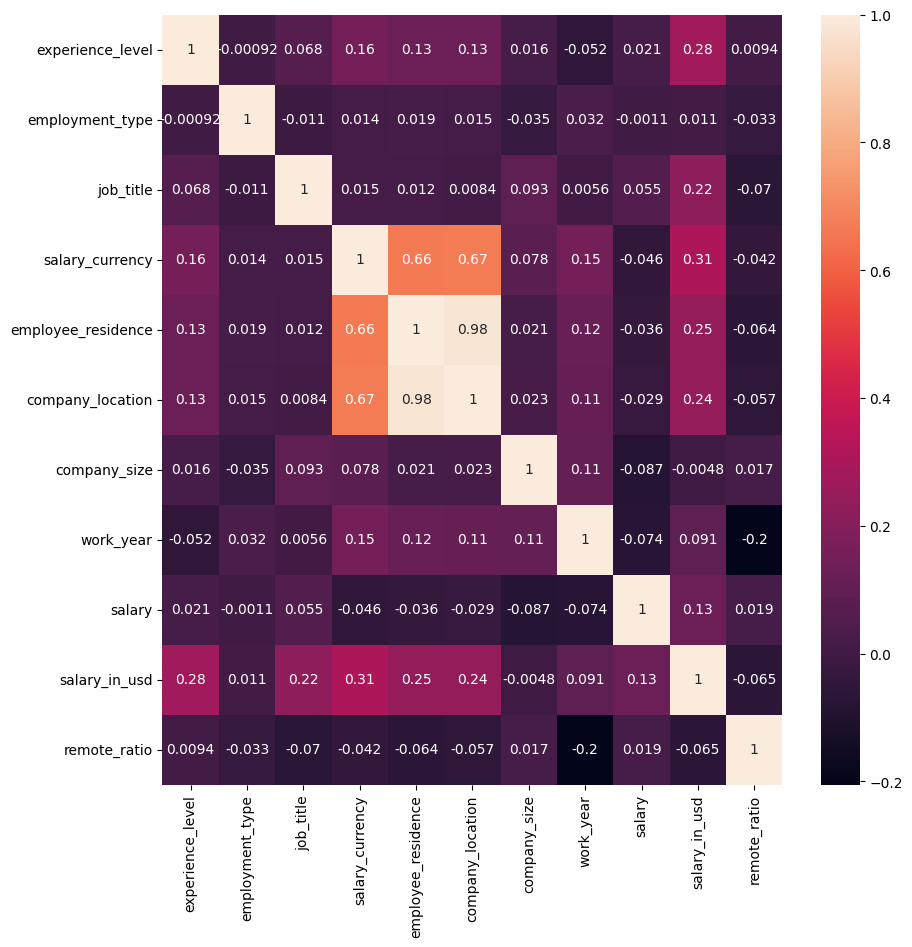

In [76]:
hm_data = pd.concat([cat_cols, num_col], axis=1)
fig, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(hm_data.corr(), annot=True)

### Средняя заработной платы в зависимости от опыта сотрудника

In [77]:
data['experience_level'].value_counts()

,count
experience_level,
SE,9696
MI,3553
EN,1148
EX,441


EN - Junior, MI - Mid-level, SE - Senior, EX - Expert

Text(0.5, 1.0, 'experience_level')

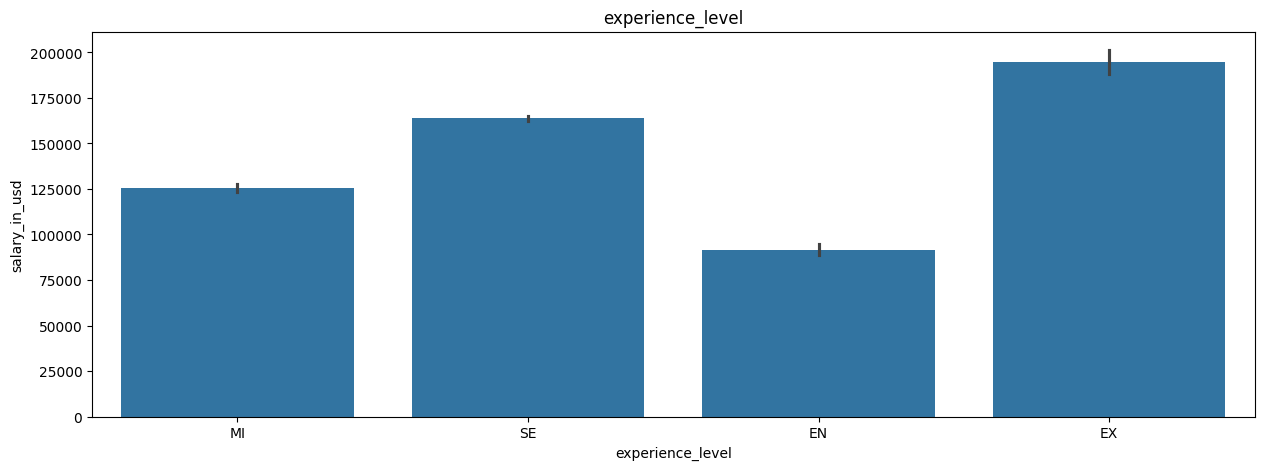

In [78]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'experience_level', y = 'salary_in_usd')
axes.set_title('experience_level')

среднее значение зарплат в зависимости от опыта сотрудника по годам

In [79]:
data.groupby(['experience_level','work_year'])['salary_in_usd'].mean()

experience_level  work_year
EN                2020          69840.666667
                  2021          63463.065217
                  2022          80018.698276
                  2023          91166.310345
                  2024          98308.906188
EX                2020         179958.250000
                  2021         186128.000000
                  2022         188260.292683
                  2023         191314.194215
                  2024         203320.854167
MI                2020          91870.935484
                  2021          86818.390805
                  2022         102733.432961
                  2023         123821.311772
                  2024         136547.600294
SE                2020         138648.894737
                  2021         125989.746667
                  2022         147982.512753
                  2023         165421.026078
                  2024         168214.908784
Name: salary_in_usd, dtype: float64

In [80]:
Junior = data.loc[data['experience_level'] == 'EN']
Expert = data.loc[data['experience_level'] == 'EX']
Mid_level = data.loc[data['experience_level'] == 'MI']
Senior = data.loc[data['experience_level'] == 'SE']

Text(0.5, 1.0, 'Expert')

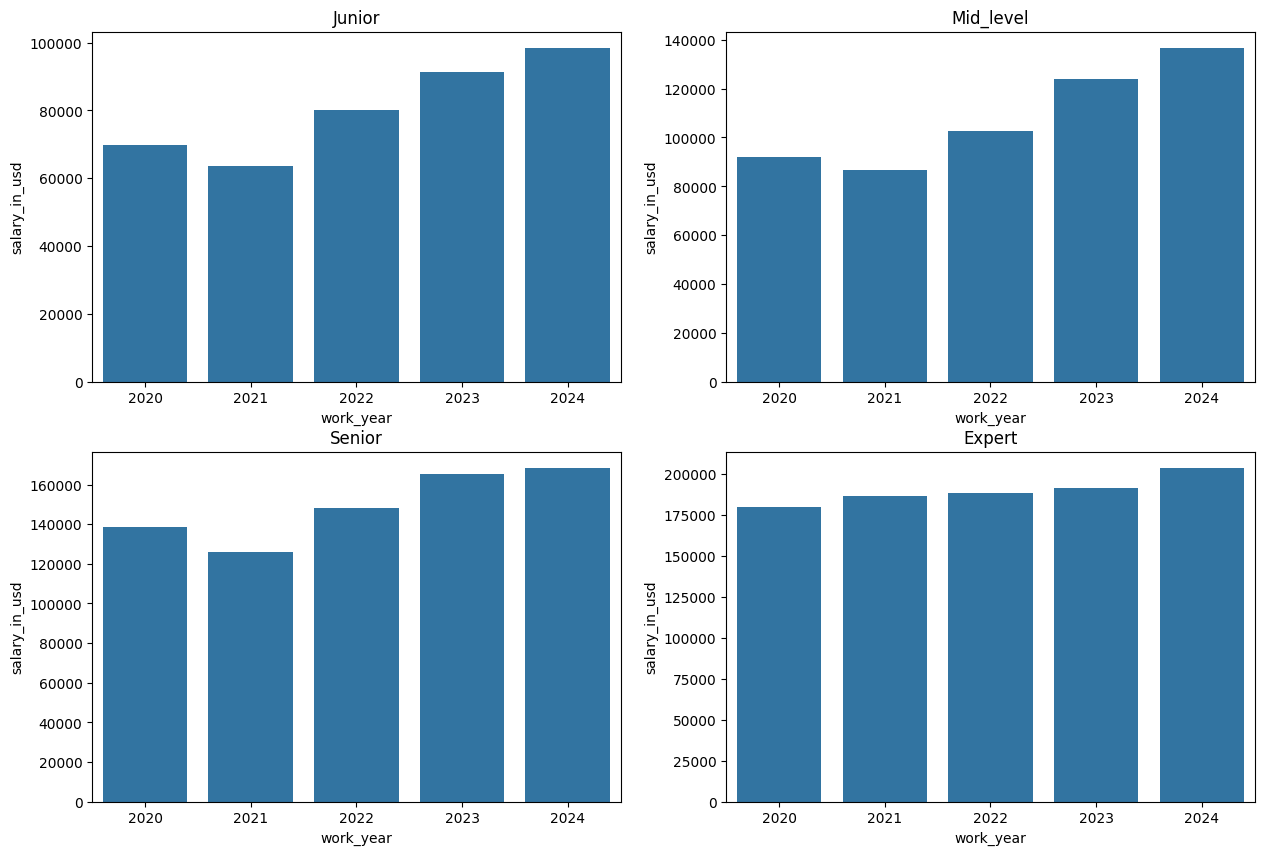

In [81]:
аfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.barplot(Junior.groupby('work_year')['salary_in_usd'].mean(), ax = axes[0, 0])
axes[0, 0].set_title('Junior')
sns.barplot(Mid_level.groupby('work_year')['salary_in_usd'].mean(), ax = axes[0, 1])
axes[0, 1].set_title('Mid_level')
sns.barplot(Senior.groupby('work_year')['salary_in_usd'].mean(), ax = axes[1, 0])
axes[1, 0].set_title('Senior')
sns.barplot(Expert.groupby('work_year')['salary_in_usd'].mean(), ax = axes[1, 1])
axes[1, 1].set_title('Expert')

Text(0.5, 1.0, 'Expert')

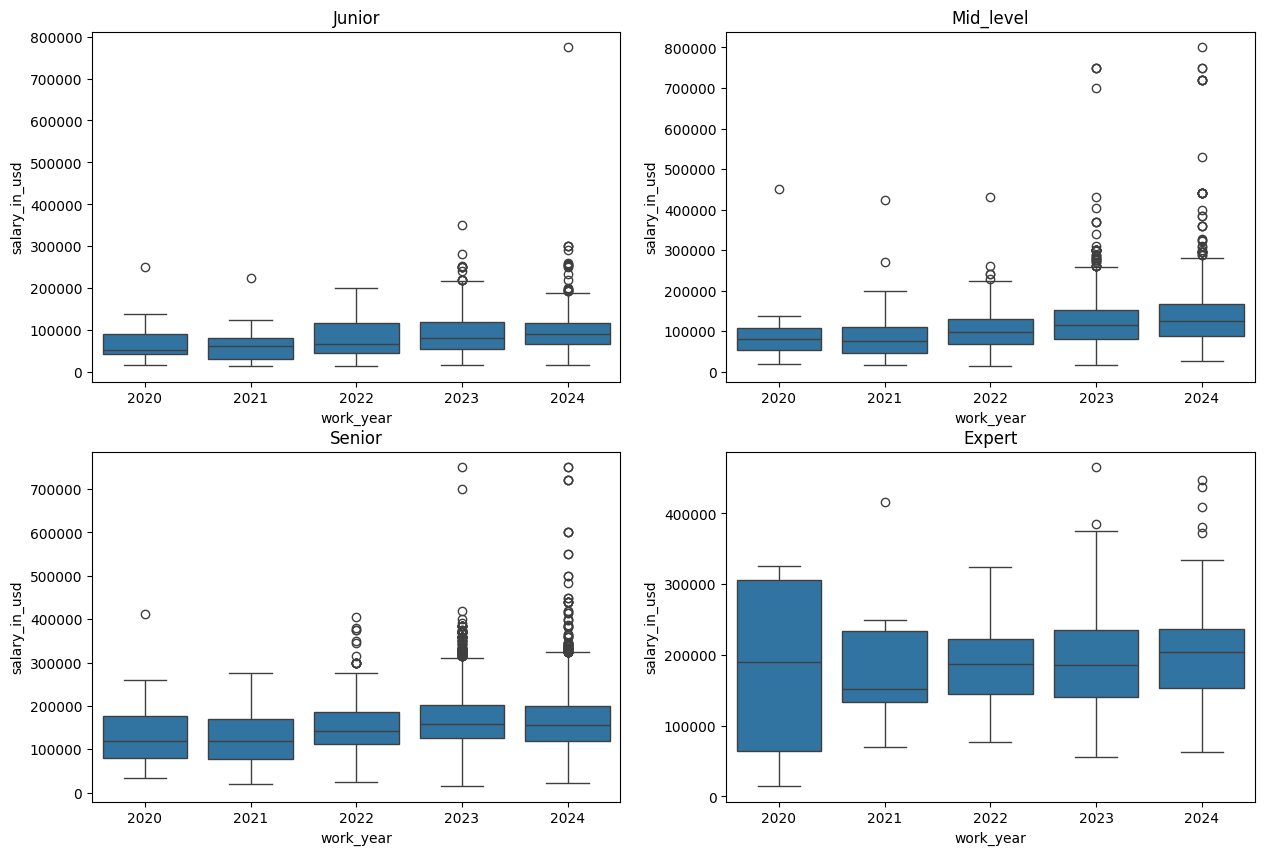

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.boxplot(Junior, x = 'work_year', y = 'salary_in_usd', ax = axes[0, 0])
axes[0, 0].set_title('Junior')
sns.boxplot(Mid_level, x = 'work_year', y = 'salary_in_usd', ax = axes[0, 1])
axes[0, 1].set_title('Mid_level')
sns.boxplot(Senior, x = 'work_year', y = 'salary_in_usd', ax = axes[1, 0])
axes[1, 0].set_title('Senior')
sns.boxplot(Expert, x = 'work_year', y = 'salary_in_usd', ax = axes[1, 1])
axes[1, 1].set_title('Expert')

###Зависимость заработной платы сотрудников от размера компании

Text(0.5, 1.0, 'company_size')

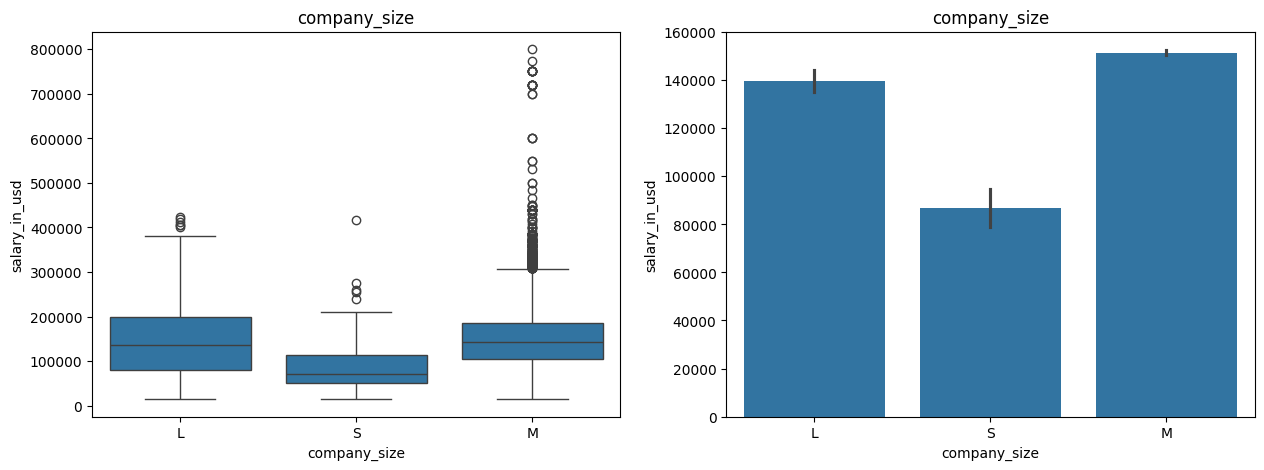

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.boxplot(data, x = 'company_size', y = 'salary_in_usd', ax = axes[0])
axes[0].set_title('company_size')
sns.barplot(data, x = 'company_size', y = 'salary_in_usd', ax = axes[1])
axes[1].set_title('company_size')

###Зависимость заработной платы от страны расположения компании

Text(0.5, 1.0, 'company_location')

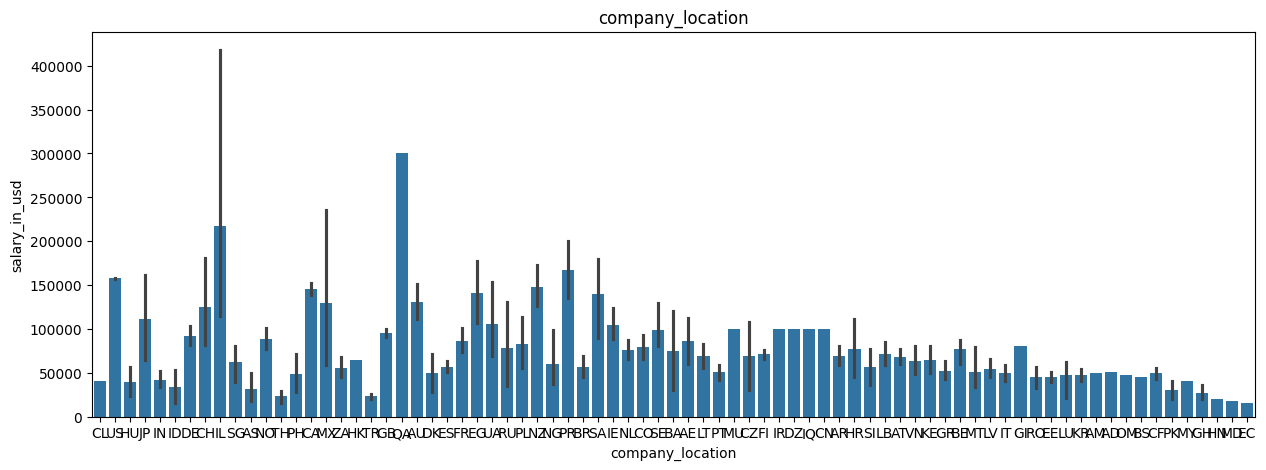

In [84]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'company_location', y = 'salary_in_usd')
axes.set_title('company_location')

###Зависимость заработной платы от места жительства сотрудника

Text(0.5, 1.0, 'employee_residence')

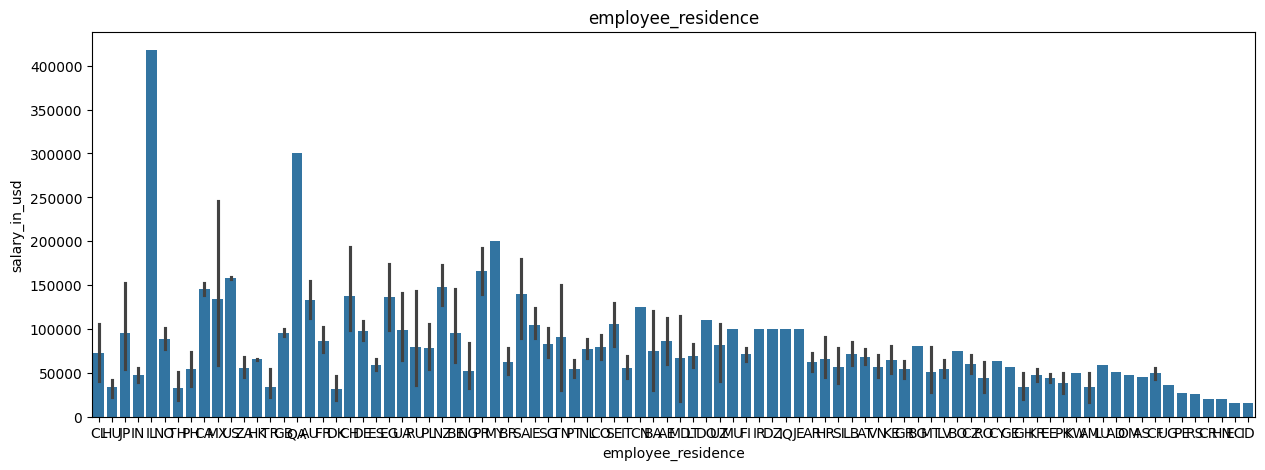

In [85]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'employee_residence', y = 'salary_in_usd')
axes.set_title('employee_residence')

###Зависимость заработной платы от должности сотрудника

Text(0.5, 1.0, 'job_title')

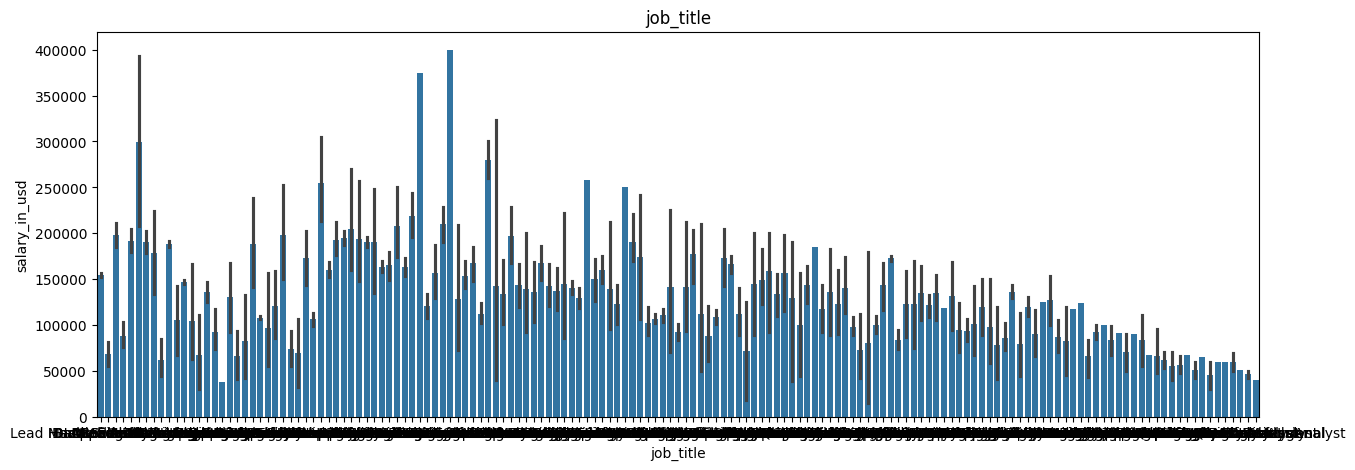

In [86]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'job_title', y = 'salary_in_usd')
axes.set_title('job_title')

#

##Обработка данных

Для заработной платы применяем Label Encoding

In [87]:
df = data.copy()

le = LabelEncoder()
le.fit(df['salary_in_usd'])
df['salary_in_usd'] = le.transform(df['salary_in_usd'])

Для опыта сотрудников и размера компании применяем порядковое кодирование. EN - Junior, MI - Mid-level, SE - Senior, EX - Expert.


In [88]:
df['experience_level'] = df['experience_level'].replace('EN', 1)
df['experience_level'] = df['experience_level'].replace('MI', 2)
df['experience_level'] = df['experience_level'].replace('SE', 3)
df['experience_level'] = df['experience_level'].replace('EX', 4)

df['company_size'] = df['company_size'].replace('S', 1)
df['company_size'] = df['company_size'].replace('M', 2)
df['company_size'] = df['company_size'].replace('L', 3)

Столбецы с валютой заработной платы и заработной платой в определенной валюте считаю лишними переменными в базе данных, т.к есть обобщенный стоблец заработной платы в USD.



In [89]:
del df['salary_currency']
del df['salary']

Так же в связи с малым количеством данных в стоблце employment_type отличных от FT, удаляем данные.

In [90]:
df = df.drop(df[df['employment_type'] == 'PT'].index)
df = df.drop(df[df['employment_type'] == 'CT'].index)
df = df.drop(df[df['employment_type'] == 'FL'].index)
del df['employment_type']
df = df.reset_index()
del df['index']
df

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,2,Data Scientist,145,CL,100,CL,3
1,2021,2,BI Data Analyst,116,HU,50,US,3
2,2020,2,Data Scientist,114,HU,50,HU,3
3,2021,2,ML Engineer,593,JP,50,JP,1
4,2022,3,Lead Machine Learning Engineer,844,IN,50,IN,3
...,...,...,...,...,...,...,...,...
14767,2022,1,Research Engineer,8,RU,100,RU,2
14768,2022,2,Business Intelligence Developer,0,GH,100,GH,2
14769,2020,4,Staff Data Analyst,0,NG,0,CA,2
14770,2021,1,Machine Learning Developer,0,TH,100,TH,3


Для должности работника применяем OneHotEncoder

In [119]:
ohe = OneHotEncoder()
res_jt = ohe.fit_transform(df['job_title'].to_numpy().reshape(-1, 1))
ohe_jt = pd.DataFrame(res_jt.toarray(), columns=ohe.get_feature_names_out())

ohe_jt = pd.get_dummies(df['job_title'], prefix='job_title', drop_first=True)

так же применяем OneHotEncoder для места жительства сотрудника и страны расположения компании

In [120]:
res_er = ohe.fit_transform(df['employee_residence'].to_numpy().reshape(-1, 1))
ohe_er = pd.DataFrame(res_er.toarray(), columns=ohe.get_feature_names_out())

ohe_er = pd.get_dummies(df['employee_residence'], prefix='employee_residence', drop_first=True)

res_cl = ohe.fit_transform(df['company_location'].to_numpy().reshape(-1, 1))
ohe_cl = pd.DataFrame(res_cl.toarray(), columns=ohe.get_feature_names_out())

ohe_cl = pd.get_dummies(df['company_location'], prefix='company_location', drop_first=True)

In [121]:
df_test = pd.concat([df, ohe_jt, ohe_cl, ohe_er], axis=1)
del df_test['job_title']
del df_test['employee_residence']
del df_test['company_location']
df_test.head()

,work_year,experience_level,salary_in_usd,remote_ratio,company_size,job_title_AI Developer,job_title_AI Engineer,job_title_AI Product Manager,job_title_AI Programmer,job_title_AI Research Engineer,...,employee_residence_SI,employee_residence_TH,employee_residence_TN,employee_residence_TR,employee_residence_UA,employee_residence_UG,employee_residence_US,employee_residence_UZ,employee_residence_VN,employee_residence_ZA
0,2021,2,145,100,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2021,2,116,50,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2020,2,114,50,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2021,2,593,50,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2022,3,844,50,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


###Разделение признаков на тренировочные и тестовые

Данные с кодированием признаков OneHotEncoder

In [122]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    df_test.drop(columns='salary_in_usd'),
    df_test['salary_in_usd'],
    random_state=2024,
    test_size=0.3
)

###Масштабирование признаков

In [123]:
scaler = StandardScaler()
X_train_scaled_ohe = pd.DataFrame(
    scaler.fit_transform(X_train_ohe),
    columns=X_train_ohe.columns
)
X_test_scaled_ohe = pd.DataFrame(
    scaler.transform(X_test_ohe),
    columns=X_test_ohe.columns
)

In [124]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

##Выбор метрики

Для оценки качества модели предлогается использовать метрику MAE, ввиду ее простой интерпретации и т.к в данных присутствуют выбросы, которые влияют на метрику MSE.

##Базовые модели

Для предсказания заработной платы сотрудника по заданным базой данных признакам кажется наиболее подходящими базовыми моделями являются: Линейная регрессия, линейная регрессия с регуляризацией.


###Константное предсказание

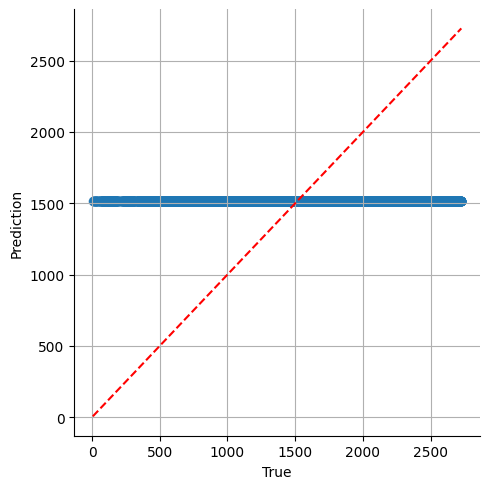

MAE: 565.9111010830325


In [125]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train_scaled_ohe, y_train_ohe)
y_pred_dummy = dummy.predict(X_test_scaled_ohe)

plot_model_results(y_test_ohe, y_pred_dummy, title = '')

print(f"MAE: {mean_absolute_error(y_test_ohe, y_pred_dummy)}")

###Линейная регрессия

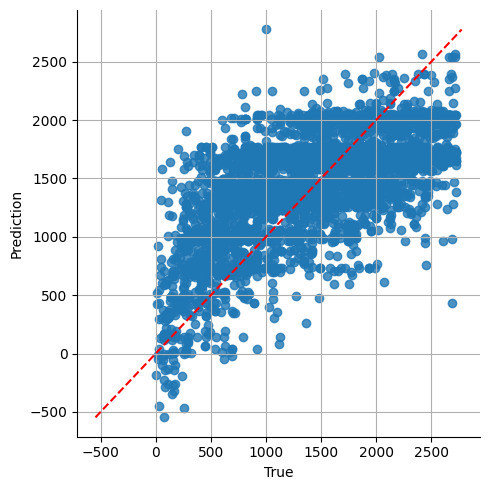

MAE: 422.1752585542669


In [126]:
lr = LinearRegression()
lr.fit(X_train_scaled_ohe, y_train_ohe)
y_preds_lr = lr.predict(X_test_scaled_ohe)

plot_model_results(y_test_ohe, y_preds_lr, title = '')

print(f"MAE: {mean_absolute_error(y_test_ohe, y_preds_lr)}")

###Линейная регрессия с регуляризацией

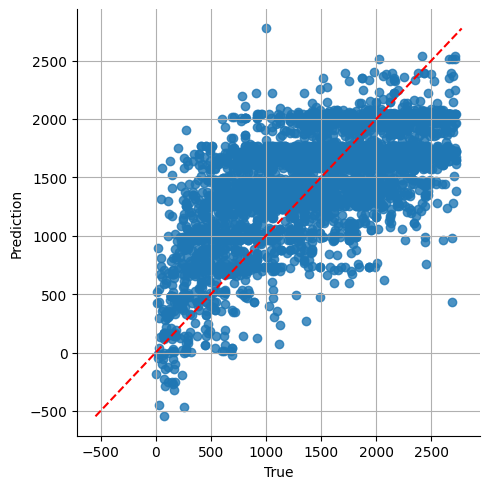

MAE: 422.02840699631633


In [127]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled_ohe, y_train_ohe)
y_preds = ridge.predict(X_test_scaled_ohe)

plot_model_results(y_test_ohe, y_preds, title = '')

print(f"MAE: {mean_absolute_error(y_test_ohe, y_preds)}")

##Выводы

При измерение качества базовой модели на тестовой выборке с использованием метрики Средняя абсолютная ошибка (MAE) для константного предсказания MAE: 565.9111010830325, для Линейной регресии MAE: 421.61473519527823 и для Линейной регрессии с регуляризацией MAE: 421.6034645658604.
Данная модель позляет оценить величину зарабтной платы научного сотрудника с средней ошибкой в $421.

#Задание №2

##В качестве более сложной модели обучения выбран градиентный бустинг.

In [128]:
print(list(X_train_scaled_ohe.columns))

['work_year', 'experience_level', 'remote_ratio', 'company_size', 'job_title_AI Developer', 'job_title_AI Engineer', 'job_title_AI Product Manager', 'job_title_AI Programmer', 'job_title_AI Research Engineer', 'job_title_AI Research Scientist', 'job_title_AI Scientist', 'job_title_AI Software Engineer', 'job_title_AWS Data Architect', 'job_title_Admin & Data Analyst', 'job_title_Analytics Engineer', 'job_title_Analytics Engineering Manager', 'job_title_Applied Data Scientist', 'job_title_Applied Machine Learning Engineer', 'job_title_Applied Machine Learning Scientist', 'job_title_Applied Research Scientist', 'job_title_Applied Scientist', 'job_title_Autonomous Vehicle Technician', 'job_title_Azure Data Engineer', 'job_title_BI Analyst', 'job_title_BI Data Analyst', 'job_title_BI Data Engineer', 'job_title_BI Developer', 'job_title_Big Data Architect', 'job_title_Big Data Developer', 'job_title_Big Data Engineer', 'job_title_Business Data Analyst', 'job_title_Business Intelligence', 'j

In [150]:
model = CatBoostRegressor()
parameters = {'learning_rate': (0.01, 1, 5),
        'depth': list(range(3, 10)),
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = model.randomized_search(parameters,
                                                   X=X_train_scaled_ohe,
                                                   y=y_train_ohe,
                                                   cv=5,
                                                   partition_random_seed=2024,
                                                   refit=True)

0:	learn: 622.2715999	test: 616.3089470	best: 616.3089470 (0)	total: 1.88ms	remaining: 1.88s
1:	learn: 564.1577077	test: 554.5073677	best: 554.5073677 (1)	total: 3.57ms	remaining: 1.78s
2:	learn: 554.6561640	test: 542.7390927	best: 542.7390927 (2)	total: 5.25ms	remaining: 1.75s
3:	learn: 546.6228979	test: 535.0106589	best: 535.0106589 (3)	total: 6.91ms	remaining: 1.72s
4:	learn: 538.8166852	test: 534.7387409	best: 534.7387409 (4)	total: 8.53ms	remaining: 1.7s
5:	learn: 536.7044059	test: 532.3482857	best: 532.3482857 (5)	total: 10.1ms	remaining: 1.67s
6:	learn: 533.5722883	test: 528.3196784	best: 528.3196784 (6)	total: 11.7ms	remaining: 1.66s
7:	learn: 531.3800423	test: 524.5861275	best: 524.5861275 (7)	total: 13.4ms	remaining: 1.66s
8:	learn: 529.0455350	test: 521.6138062	best: 521.6138062 (8)	total: 14.9ms	remaining: 1.64s
9:	learn: 526.5270711	test: 519.9438684	best: 519.9438684 (9)	total: 16.6ms	remaining: 1.64s
10:	learn: 524.1438963	test: 517.9535105	best: 517.9535105 (10)	total: 

learning rate is greater than 1. You probably need to decrease learning rate.


57:	learn: 114036353190482755468950199988184416256.0000000	test: 114019059942633020621259299141520982016.0000000	best: 5992.8150218 (0)	total: 135ms	remaining: 2.2s
58:	learn: 455559113061830945618119060906892591104.0000000	test: 455489876385062979130008011933921312768.0000000	best: 5992.8150218 (0)	total: 137ms	remaining: 2.19s
59:	learn: 1819894993875375615098416331581269475328.0000000	test: 1819618430704911637984693504521875226624.0000000	best: 5992.8150218 (0)	total: 143ms	remaining: 2.24s
60:	learn: 7269851376642682960410812232167447330816.0000000	test: 7269855808879450072706725430284873891840.0000000	best: 5992.8150218 (0)	total: 146ms	remaining: 2.24s
61:	learn: 29040510109089068225514494299112722137088.0000000	test: 29036464320864845959597391016237429948416.0000000	best: 5992.8150218 (0)	total: 147ms	remaining: 2.22s
62:	learn: 116003751668683253589492743221881308446720.0000000	test: 116002161985022514136690723013098590961664.0000000	best: 5992.8150218 (0)	total: 149ms	remainin

CatBoostError: catboost/private/libs/algo/tensor_search_helpers.cpp:99: This should be unreachable

In [144]:
y_preds = model.predict(X_test_scaled_ohe)

In [145]:
print(f"MAE: {mean_absolute_error(y_test_ohe, y_preds)}")

MAE: 414.10121453229334
